In [1]:
import seaborn as sns
import pandas as pd
import datetime
import altair as alt
import glob
import os
import warnings
warnings.filterwarnings('ignore')

# CAS Data Science Projekt Sleep Analysis - Data Wrangling

## Datenquellen

**Mond Phasen**
Abruf: 03.04.2022
Quelle: `https://www.timeanddate.de/mond/phasen/` (Location: Basel). Händischer Download in ein CSV ohne Spalte Lunation und Duration
Dateien: `raw/moon/*`

**Schlafdaten**
Abruf: 18.06.2022
Quelle: Daten Export von Fitbit Schlafdaten von privatem Account, CSV Export
Dateien: `raw/sleep/*` `raw/heart/*` `raw/temp/*`

## 1. Mond-Phasen

### 1.1 Datenaufbereitung

Ich habe diese zwei kleinen Tabellen (2021, 2022) von Hand in ein Excel bzw. CSV kopiert, da der Aufwand einen Crawler zu schreiben für diese paar Zeilen dafür zu gross gewesen wäre. Nun muss ich die Daten in ein geeignetes Format bringen. Grundsätzlich möchte ich pro Datum wissen, welche Mondphase das ist.

In [2]:
# read data
moon2021_raw = pd.read_csv('raw/moon/moon-phases-2021.csv')
moon2022_raw = pd.read_csv('raw/moon/moon-phases-2022.csv')

# have a look
print(moon2021_raw.head())
print(moon2022_raw.head())

# drop unnecessary column
moon2021_raw.drop('Unnamed: 4', inplace=True, axis=1)
moon2022_raw.drop('Unnamed: 4', inplace=True, axis=1)

# have a look again
print(moon2021_raw.head())
print(moon2022_raw.head())

     New Moon First Quarter   Full Moon Third Quarter  Unnamed: 4
0  2021-01-13    2021-01-20  2021-01-28    2021-01-06         NaN
1  2021-02-11    2021-02-19  2021-02-27    2021-02-04         NaN
2  2021-03-13    2021-03-21  2021-03-28    2021-03-06         NaN
3  2021-04-12    2021-04-20  2021-04-27    2021-04-04         NaN
4  2021-05-11    2021-05-19  2021-05-26    2021-05-03         NaN
     New Moon First Quarter   Full Moon Third Quarter  Unnamed: 4
0  2022-01-02    2022-01-09  2022-01-18    2022-01-25         NaN
1  2022-02-01    2022-02-08  2022-02-16    2022-02-23         NaN
2  2022-03-02    2022-03-10  2022-03-18    2022-03-25         NaN
3  2022-04-01    2022-04-09  2022-04-16    2022-04-23         NaN
4  2022-04-30    2022-05-09  2022-05-16    2022-05-22         NaN
     New Moon First Quarter   Full Moon Third Quarter
0  2021-01-13    2021-01-20  2021-01-28    2021-01-06
1  2021-02-11    2021-02-19  2021-02-27    2021-02-04
2  2021-03-13    2021-03-21  2021-03-28    202

In [3]:

def convert_all_dates(df, format):
    """Converts all the date strings into proper datetime objects."""

    new_moon = 'New Moon'
    df[new_moon] = pd.to_datetime(df[new_moon], format=format)
    first_quarter = 'First Quarter'
    df[first_quarter] = pd.to_datetime(df[first_quarter], format=format)
    full_moon = 'Full Moon'
    df[full_moon] = pd.to_datetime(df[full_moon], format=format)
    third_quarter = 'Third Quarter'
    df[third_quarter] = pd.to_datetime(df[third_quarter], format=format)

    return df

In [4]:
format = '%Y-%m-%d'
moon2021_raw = convert_all_dates(moon2021_raw, format)
moon2022_raw = convert_all_dates(moon2022_raw, format)

print(moon2021_raw.dtypes)
print(moon2022_raw.dtypes)


New Moon         datetime64[ns]
First Quarter    datetime64[ns]
Full Moon        datetime64[ns]
Third Quarter    datetime64[ns]
dtype: object
New Moon         datetime64[ns]
First Quarter    datetime64[ns]
Full Moon        datetime64[ns]
Third Quarter    datetime64[ns]
dtype: object


In [5]:
def flatten_moon_phases(df):
    """Flattens the moon phases to dates e.g. 2020-01-01 New Moon"""
    flattened = pd.DataFrame(columns={'Date', 'Moon Phase'})
    for index, row in df.iterrows():

        first_quarter = {'Date': row['First Quarter'], 'Moon Phase': 'First Quarter'}
        flattened = flattened.append(first_quarter, ignore_index = True)

        new_moon = {'Date': row['New Moon'], 'Moon Phase': 'New Moon'}
        flattened = flattened.append(new_moon, ignore_index = True)

        third_quarter = {'Date': row['Third Quarter'], 'Moon Phase': 'Third Quarter'}
        flattened = flattened.append(third_quarter, ignore_index = True)

        full_moon = {'Date': row['Full Moon'], 'Moon Phase': 'Full Moon'}
        flattened = flattened.append(full_moon, ignore_index = True)


    return flattened

In [6]:
moon_2021 = flatten_moon_phases(moon2021_raw)
moon_2022 = flatten_moon_phases(moon2022_raw)

moon_2021.rename(columns={'Date': 'date'}, inplace=True)
moon_2022.rename(columns={'Date': 'date'}, inplace=True)

moon_2021['date'] = pd.to_datetime(moon_2021["date"])
moon_2022['date'] = pd.to_datetime(moon_2022["date"])

In [7]:
# drop ones containing no date
moon_2021.dropna(axis=0, inplace=True)
moon_2022.dropna(axis=0, inplace=True)

### 1.2 Fertige Datensätze

In [8]:
print("File Mond Phasen 2021 Dimensionen: "+ str(moon_2021.shape))
moon_2021.tail(10)

File Mond Phasen 2021 Dimensionen: (49, 2)


,date,Moon Phase
39,2021-10-20,Full Moon
40,2021-11-11,First Quarter
41,2021-11-04,New Moon
42,2021-10-28,Third Quarter
43,2021-11-19,Full Moon
44,2021-12-11,First Quarter
45,2021-12-04,New Moon
46,2021-11-27,Third Quarter
47,2021-12-19,Full Moon
50,2021-12-27,Third Quarter


In [9]:
print("File Mond Phasen 2022 Dimensionen: "+ str(moon_2022.shape))
moon_2022.tail(10)

File Mond Phasen 2022 Dimensionen: (50, 2)


,date,Moon Phase
40,2022-11-01,First Quarter
41,2022-10-25,New Moon
42,2022-11-16,Third Quarter
43,2022-11-08,Full Moon
44,2022-11-30,First Quarter
45,2022-11-23,New Moon
46,2022-12-16,Third Quarter
47,2022-12-08,Full Moon
48,2022-12-30,First Quarter
49,2022-12-23,New Moon


In [10]:
# combined
combined_moon = moon_2021.merge(moon_2022, how='outer',on=['date','Moon Phase'])
combined_moon.shape



(99, 2)

In [11]:

sdate = datetime.date(2021, 12, 11)
edate = datetime.date(2022, 6, 20)
all_dates = pd.DataFrame(pd.date_range(sdate, edate), columns=['date'])

## from the all_dates DataFrame, left join onto the DataFrame with missing dates
combined_moon = all_dates.merge(right=combined_moon, how='left', on='date')
combined_moon['Moon Phase'].ffill(limit=2, inplace=True)
combined_moon['Moon Phase'].bfill(limit=2, inplace=True)

combined_moon.to_csv('prepared/moon.csv')

In [12]:
combined_moon.shape

(192, 2)

### 1.3 Erste Visualisierungen

<AxesSubplot:xlabel='Moon Phase', ylabel='count'>

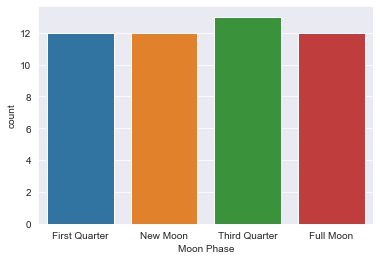

In [13]:
sns.countplot(data=moon_2021, x='Moon Phase')

In [14]:
from altair.utils.data import to_values

alt.Chart.from_dict({
    "data": to_values(moon_2021),
    "mark": "circle",
    "encoding": {
        "x": {
            "field": "date",
            "type": "temporal",
        },
        "color": {
            "field": "Moon Phase",
            "type": "nominal"
        },
         "y": {
            "field": "Moon Phase",
            "type": "nominal",
        }
    }
})

alt.Chart(...)

Die Mond-Phasen sind verteilt wie erwaret.

## 2. Fitbit - Average Heart Rate

### 2.1 Datenaufbereitung

In [15]:
def get_bpm(row):
    entry = row['value']
    return entry['bpm']

def get_confidence(row):
    value = row['value']
    return value['confidence']

In [16]:

# does not respect confidence yet (confidence 3 is best, 0 is lowest)
def process_heart_df(dataframe):
    dataframe['date'] = pd.to_datetime(dataframe['dateTime']).dt.date
    dataframe.drop(columns=['dateTime'], inplace=True)
    dataframe['bpm'] = dataframe.apply(get_bpm, axis=1)
    dataframe['confidence'] = dataframe.apply(get_confidence, axis=1)
    dataframe = dataframe[dataframe.confidence > 2]
    dataframe.drop(columns=['value'], inplace=True)
    dataframe = dataframe.groupby('date', sort=False)['bpm'].mean().reset_index()
    return dataframe

In [ ]:
# care, this takes a while - grab a coffee

heart_path = os.path.abspath("raw/heart")
heart_filenames = glob.glob(heart_path + "/*.json")
dfs = []

for filename in heart_filenames:
    read = pd.read_json(filename)
    df = process_heart_df(read)
    dfs.append(df)

heart = pd.concat(dfs)
heart.reset_index(drop=True, inplace=True)

heart['date'] = pd.to_datetime(heart["date"])


In [ ]:
heart = heart.groupby(['date']).mean()
print(heart.shape)

### 2.2 Fertiger Datensatz

In [ ]:
heart.rename(columns={'bpm':'avg_bpm'}, inplace=True)
heart.to_csv('prepared/heart.csv')
print("File Heart Rate Dimensionen: "+ str(heart.shape))
heart.tail(10)

### 2.3 Erste Visualisierungen

In [ ]:
sns.histplot(data=heart)

Die häufigsten durchschnittlichen Vorkommnisse sind zwischen 55-65 bpm. Das scheint okay zu sein.
Die Ober- (ca. 75) und Untergrenzen (ca. 50) scheinen auch gut möglich.

## 3. Fitbit - Temperatur Abweichungen

### 3.1 Datenaufbereitung

In [ ]:

def process_temp_df(dataframe):
    dataframe.drop(columns=['sensor_type'], inplace=True)
    dataframe['date'] = pd.to_datetime(dataframe['recorded_time']).dt.date
    dataframe.drop(columns=['recorded_time'], inplace=True)
    dataframe = dataframe.groupby('date', sort=False)['temperature'].mean().reset_index()
    return dataframe

In [ ]:
# care, this takes a while - grab a coffee

temp_path = os.path.abspath("raw/temp")
temp_filenames = glob.glob(temp_path + "/*.csv")
temp_dfs = []

for filename in temp_filenames:
    read = pd.read_csv(filename)
    processed = process_temp_df(read)
    temp_dfs.append(processed)

temp = pd.concat(temp_dfs)
temp.reset_index(drop=True, inplace=True)
temp['date'] = pd.to_datetime(temp["date"])
temp.rename(columns={'temperature':'temp_delta'}, inplace=True)


In [ ]:
temp.head()

### 3.2 Fertiger Datensatz

In [ ]:
baseline_temp = 33
temp['skin_temp_avg'] = temp['temp_delta'].apply(lambda x: baseline_temp+x)
temp.drop(columns=['temp_delta'], inplace=True)

temp.to_csv('prepared/temp.csv')
temp.tail(10)

### 3.3 Erste Visualisierungen

In [ ]:
sns.histplot(data=temp)

Die häufigsten durchschnittlichen Vorkommnisse sind rund um 31 Grad Celsius, dies scheint normal zu sein für Haupttemperatur. Diese Daten streuen auch nicht sehr weit, was ein wichtiges Zeichen ist.

## 4. Fitbit - Sleep Score

### 4.1 Datenaufbereitung

In [ ]:
sleep = pd.read_csv('raw/sleep/sleep_score.csv')
sleep.sample(frac=1)
sleep.drop(columns=['sleep_log_entry_id'], inplace=True)

sleep['date'] = pd.to_datetime(sleep['timestamp']).dt.date
sleep.drop(columns=['timestamp'], inplace=True)
sleep['date'] = pd.to_datetime(sleep["date"])


In [ ]:
sleep.head()

In [ ]:
sleep.shape

### 4.2 Fertiger Datensatz

In [ ]:
sleep.to_csv('prepared/sleep.csv')
print("Sleep File Dimensionen: "+ str(sleep.shape))

### 4.3 Erste Visualisierungen

In [ ]:
sns.pairplot(sleep)



In [ ]:
corr = sleep.corr()
corr.style.background_gradient(cmap='coolwarm')

# Comparing + Combination of Datasets

In [ ]:
def pp_shape(df, name):
    print("Dataframe "+ name+" has a shape of "+   str((df.shape)))

pp_shape(combined_moon, "moon")
pp_shape(heart, "heart rate")
pp_shape(temp, "temperature")
pp_shape(sleep, "sleep")

In [ ]:
temp_sleep = temp.merge(sleep, on='date', how='left')
print(temp_sleep.shape)
temp_sleep.head(5)

In [ ]:
fitbit_data = temp_sleep.merge(heart, on='date', how='left')
fitbit_data.to_csv('prepared/fitbit_data.csv')
fitbit_data.shape

In [ ]:
fitbit_data.sample(frac=1)

In [ ]:
sns.pairplot(fitbit_data)

In [ ]:
fitbit_data.to_csv('prepared/prepared-fitbit.csv')

In [ ]:
corr2 = fitbit_data.corr()
corr2.style.background_gradient(cmap='coolwarm')

In [ ]:
sns.scatterplot(x=fitbit_data['date'], y=fitbit_data['deep_sleep_in_minutes'])


In [ ]:
fitbit_data['date'] = pd.to_datetime(fitbit_data["date"])
alt.Chart.from_dict({
    "data": to_values(fitbit_data),
    "mark": "circle",
    "encoding": {
        "x": {
            "field": "date",
            "type": "temporal",
        },
        "color": {
            "field": "deep_sleep_in_minutes",
            "type": "quantitative",
        },
         "y": {
            "field": "deep_sleep_in_minutes",
            "type": "quantitative",
        }
    }
})

In [ ]:
fitbit_data.head()

In [ ]:
fitbit_data.shape

## Combination of Moon and FitBitData

In [ ]:
fitbit_data_moon = fitbit_data.merge(combined_moon, on='date', how='left')
fitbit_data_moon.shape


In [ ]:
fitbit_data_moon.head(20)

In [ ]:
fitbit_data_moon.to_csv('prepared/fitbit_data_moon.csv')

In [ ]:
crisp_moon = fitbit_data_moon.copy()

In [ ]:
crisp_moon.dropna()

In [ ]:
crisp_moon.to_csv('prepared/fitbit_data_moon_crisp.csv')

In [ ]:
crisp_moon.head(10)

In [ ]:
corr2 = crisp_moon.corr()
corr2.style.background_gradient(cmap='coolwarm')